## Sampling from a Gaussian Process

To make this notion of a “distribution over functions” more concrete, let’s quickly demonstrate how we obtain realizations from a Gaussian process, which results in an evaluation of a function over a set of points. All we will do here is a sample from the prior Gaussian process, so before any data have been introduced. What we need first is our covariance function, which will be the squared exponential, and a function to evaluate the covariance at given points (resulting in a covariance matrix).

In [1]:
import numpy as np
 
def exponential_cov(x, y, params):
    return params[0] * np.exp( -0.5 * params[1] * np.subtract.outer(x, y)**2)

We are going generate realizations sequentially, point by point, using the lovely conditioning property of mutlivariate Gaussian distributions. 
And this the function that implements it:

In [2]:
def conditional(x_new, x, y, params):

    B = exponential_cov(x_new, x, params)
    C = exponential_cov(x, x, params)
    A = exponential_cov(x_new, x_new, params)

    mu = np.linalg.inv(C).dot(B.T).T.dot(y)
    sigma = A - B.dot(np.linalg.inv(C).dot(B.T))

    return(mu.squeeze(), sigma.squeeze())

We will start with a Gaussian process prior with hyperparameters $\theta_0=1, \theta_1=10$. We will also assume a zero function as the mean, so we can plot a band that represents one standard deviation from the mean.

<ErrorbarContainer object of 3 artists>

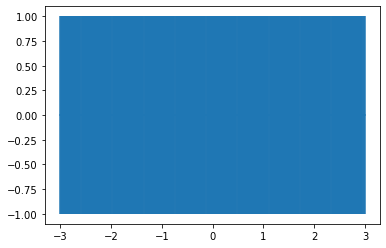

In [3]:
import matplotlib.pylab as plt
 
theta = [1, 10]
sigma_0 = exponential_cov(0, 0, theta)
xpts = np.arange(-3, 3, step=0.01)
plt.errorbar(xpts, np.zeros(len(xpts)), yerr=sigma_0, capsize=0)

Let’s select an arbitrary starting point to sample, say $x=1$. Since there are no previous points, we can sample from an unconditional Gaussian:

In [4]:
x = [1.]
y = [np.random.normal(scale=sigma_0)]
y

[-0.3667238002621664]

We can now update our confidence band, given the point that we just sampled, using the covariance function to generate new point-wise intervals, conditional on the value $[x_0, y_0]$.

In [5]:
sigma_1 = exponential_cov(x, x, theta)

In [6]:
def predict(x, data, kernel, params, sigma, t):
    k = [kernel(x, y, params) for y in data]
    Sinv = np.linalg.inv(sigma)
    y_pred = np.dot(k, Sinv).dot(t)
    sigma_new = kernel(x, x, params) - np.dot(k, Sinv).dot(k)
    return y_pred, sigma_new

x_pred = np.linspace(-3, 3, 1000)
predictions = [predict(i, x, exponential_cov, theta, sigma_1, y) for i in x_pred]

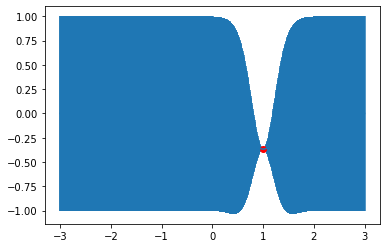

In [7]:
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro")

So conditional on this point, and the covariance structure we have specified, we have essentially constrained the probable location of additional points. Let’s now sample another:

In [8]:
x2 = -0.7
m, s = conditional(x2, x, y, theta)
y2 = np.random.normal(m, s)
y2

-0.9803467538264922

In [9]:
x.append(x2)
y.append(y2)

sigma_2 = exponential_cov(x, x, theta)
 
predictions = [predict(i, x, exponential_cov, theta, sigma_2, y) for i in x_pred]

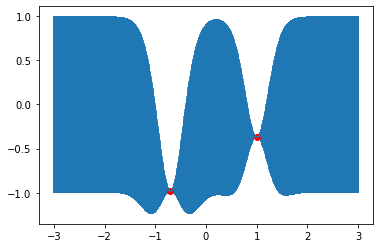

In [10]:
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro")

Of course, sampling sequentially is just a heuristic to demonstrate how the covariance structure works. We can just as easily sample several points at once:

In [11]:
x2_many = [-2.3, -1.5, 0.2, 1.5, 1.9]
m, s = conditional(x2_many, x, y, theta)

y_many = np.random.multivariate_normal(m, s)

x.extend(x2_many)
y.extend(y_many)

In [12]:
sigma_many = exponential_cov(x, x, theta)
 

In [13]:
predictions = [predict(i, x, exponential_cov, theta, sigma_many, y) for i in x_pred]

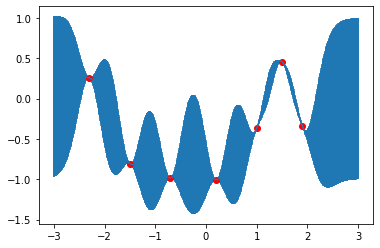

In [14]:
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro")

## TRY SKLEARN

In [15]:
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel

In [16]:
x2_many = np.random.uniform(low=-3, high=3, size=10)
m, s = conditional(x2_many, x, y, theta)

y_many = np.random.multivariate_normal(m, s)

x.extend(x2_many)
y.extend(y_many)

In [17]:
model = gaussian_process.GaussianProcessRegressor()

In [18]:
model.fit(np.array(x).reshape(-1, 1), np.array(y))

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True, kernel=None,
                         n_restarts_optimizer=0, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)

In [19]:
y_pred, sigmas = model.predict(x_pred.reshape(-1, 1), return_std=True)

C:\Users\ahn\AppData\Local\conda\conda\envs\data_loading\lib\site-packages\sklearn\gaussian_process\_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


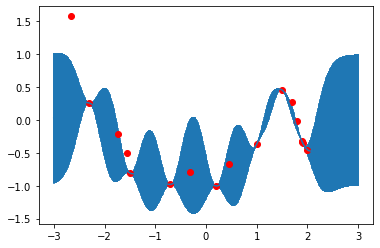

In [20]:
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro")

In [21]:
# SIMULATED DATA 
def f(x):  # true function
    return np.sin(x*10) + np.random.normal(scale=1, size=x.shape)


xpts = np.arange(-3, 3, step=0.01) 
ypts = f(ypts)

x_many = np.random.uniform(low=-3, high=3, size=10)

NameError: name 'ypts' is not defined

In [ ]:
plt.plot(xpts, ypts)

In [ ]:
plt.hist(ypts, bins=30)
plt.show()

In [ ]:
x_observations = np.random.uniform(low=-3, high=3, size=10)
y_observations = f(x_observations)

In [ ]:
# FIT MODEL TO THESE ACTUAL OBSERVATIONS

In [ ]:
model = gaussian_process.GaussianProcessRegressor()


In [ ]:
model.fit(np.array(x_observations).reshape(-1, 1), np.array(y_observations))

In [ ]:
y_pred, sigmas = model.predict(xpts.reshape(-1, 1), return_std=True)

In [ ]:
plt.errorbar(xpts, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro")

In [ ]:
xpts.shape

In [ ]:
y_pred.shape

In [ ]:
sigmas.shape